👉 Please upload your image (e.g., aeval1.bmp)


Saving aeval1.bmp to aeval1.bmp
✅ Uploaded: aeval1.bmp


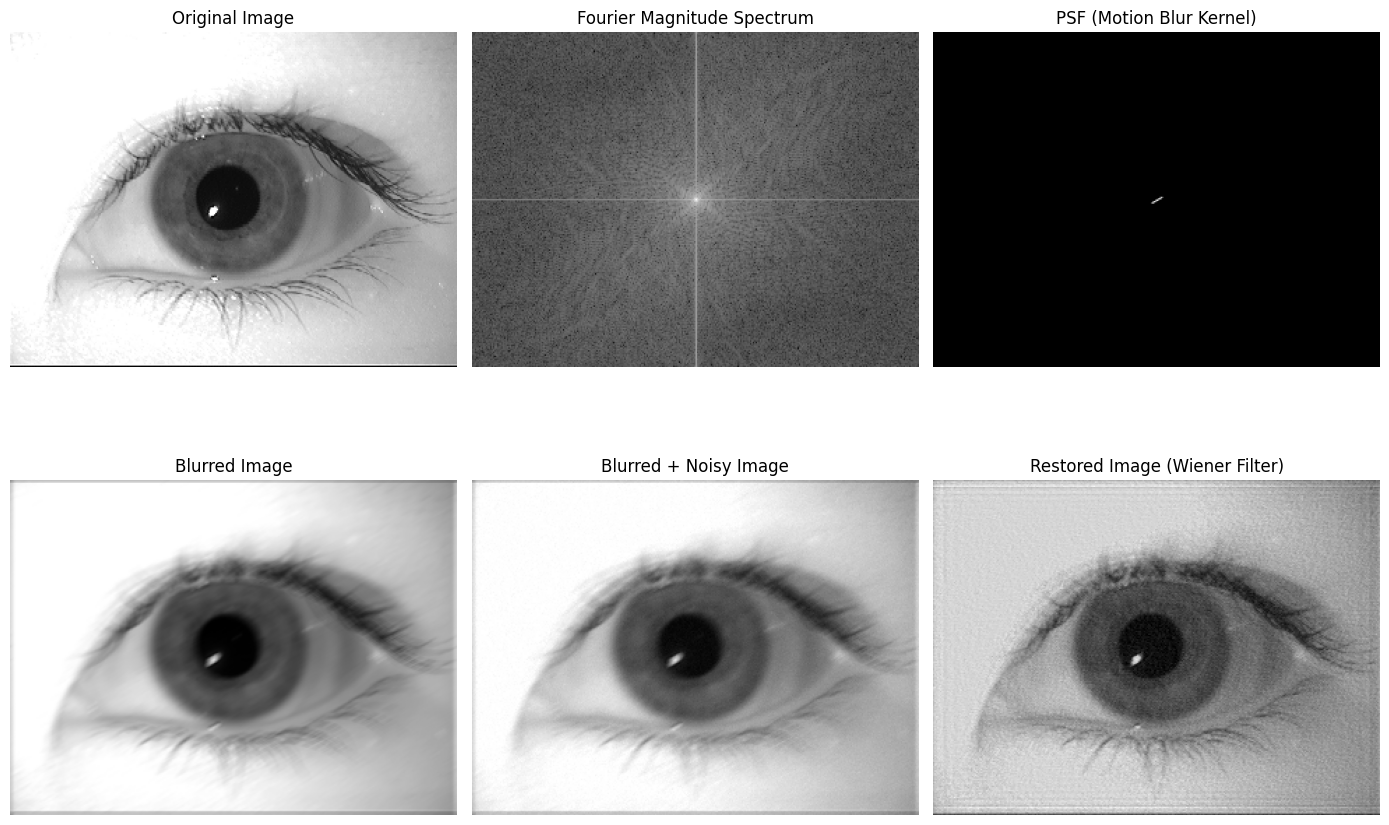

⬇️ Files ready for download:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ==========================================================
# 2D Fourier Transform and Wiener Filtering (Colab-ready)
# ==========================================================
!pip install -q opencv-python-headless matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---------------------------
# Step 1: Upload image
# ---------------------------
print("👉 Please upload your image (e.g., aeval1.bmp)")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")
image_path = next(iter(uploaded.keys()))
print(f"✅ Uploaded: {image_path}")

# ---------------------------
# Step 2: Load image & convert to grayscale
# ---------------------------
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0  # normalize [0,1]
rows, cols = img.shape

# ---------------------------
# Step 3: 2D Fourier Transform
# ---------------------------
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)  # center low frequencies
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-8)

# ---------------------------
# Step 4: Simulate degradation (motion blur + noise)
# ---------------------------
def motion_blur_psf(size, angle):
    psf = np.zeros(size)
    center = (size[0]//2, size[1]//2)
    length = min(size)//30
    cv2.line(psf,
             (center[1]-length//2, center[0]),
             (center[1]+length//2, center[0]),
             1, thickness=1)
    # rotate to desired angle
    M = cv2.getRotationMatrix2D((center[1], center[0]), angle, 1)
    psf = cv2.warpAffine(psf, M, (size[1], size[0]))
    psf /= psf.sum()
    return psf

psf = motion_blur_psf((rows, cols), angle=30)

# Apply blur via frequency-domain multiplication
H = np.fft.fft2(np.fft.ifftshift(psf))
G = H * f
blurred = np.fft.ifft2(G)
blurred = np.abs(blurred)
blurred /= blurred.max()

# Add Gaussian noise
noise = np.random.normal(0, 0.01, img.shape)
noisy_blurred = np.clip(blurred + noise, 0, 1)

# ---------------------------
# Step 5: Wiener Filtering
# ---------------------------
def wiener_filter(G, H, K=0.01):
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    F_hat = (H_conj / denom) * G
    return F_hat

K = 0.01
G_noisy = np.fft.fft2(noisy_blurred)
F_hat = wiener_filter(G_noisy, H, K=K)
restored = np.fft.ifft2(F_hat)
restored = np.abs(restored)
restored /= restored.max()

# ---------------------------
# Step 6: Visualization
# ---------------------------
plt.figure(figsize=(14,10))

plt.subplot(2,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Fourier Magnitude Spectrum")
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(psf, cmap='gray')
plt.title("PSF (Motion Blur Kernel)")
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred Image")
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(noisy_blurred, cmap='gray')
plt.title("Blurred + Noisy Image")
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(restored, cmap='gray')
plt.title("Restored Image (Wiener Filter)")
plt.axis('off')

plt.tight_layout()
plt.show()

# ---------------------------
# Step 7: Save & download outputs
# ---------------------------
cv2.imwrite("original_gray.png", (img*255).astype(np.uint8))
cv2.imwrite("magnitude_spectrum.png", cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
cv2.imwrite("blurred.png", (blurred*255).astype(np.uint8))
cv2.imwrite("noisy_blurred.png", (noisy_blurred*255).astype(np.uint8))
cv2.imwrite("restored_wiener.png", (restored*255).astype(np.uint8))

print("⬇️ Files ready for download:")
for name in ["original_gray.png", "magnitude_spectrum.png", "blurred.png", "noisy_blurred.png", "restored_wiener.png"]:
    files.download(name)
